In [138]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


ETL

In [140]:
y = data['Outcome']
X = data.drop('Outcome', axis=1)

Note that this data contains no missing values

In [141]:
X.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

The following columns contain outliers:
Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age 

In [142]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [143]:
X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [144]:
X.Pregnancies = X.Pregnancies.astype('float64')
X.Glucose = X.Glucose.astype('float64')
X.BloodPressure = X.BloodPressure.astype('float64')
X.SkinThickness = X.SkinThickness.astype('float64')
X.Insulin = X.Insulin.astype('float64')
X.Age = X.Age.astype('float64')
X.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
dtype: object

In [145]:
# remove outliers via z-score
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_X = X[filtered_entries]
new_y = y[filtered_entries]
new_y.shape
new_X.shape
# new_X.describe()



(688, 8)

In [146]:
# sns.pairplot(new_X)

Note that none of the features in the dataset are strongly correlated meaning we can assume them to be independent for the sake of creating this model

In [147]:
corr_mat = X.corr()
corr_mat

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


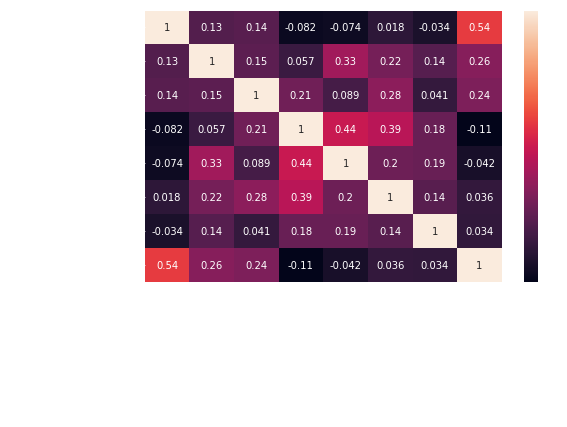

In [148]:
# Here is a better way to visualize it:
plt.figure(figsize=(8,5))
x = sns.heatmap(X.corr(),annot=True,annot_kws={"size": 10})
x.set_yticklabels(x.get_ymajorticklabels(), fontsize = 10)
x.set_xticklabels(x.get_xmajorticklabels(), fontsize = 10)
plt.show()

In [149]:
from sklearn.model_selection import KFold

In [150]:
model = GaussianNB()
cv_scores = cross_val_score(model, X, y, cv=5)
    
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GaussianNB()  mean accuracy:  75.134 % std:  0.035 %


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [152]:
y_pred = model.fit(X_train, y_train).predict(X_test)

In [153]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.765625


In [154]:
# Here is the confusion matrix for the Gaussian Naive Bayes model. 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[114,  16],
       [ 29,  33]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

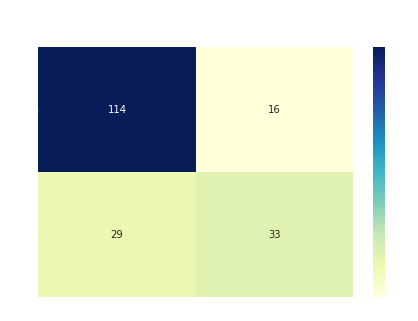

In [155]:
# Here we visualize the Gaussian Naive Bayes confusion matrix using Heatmap.
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix- Gaussian Naive Bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Hyperparameter Tuning

In [156]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [157]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=1000)

In [158]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test);

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


In [159]:
gs_NB.best_params_

{'var_smoothing': 0.3511191734215131}

In [164]:
gs_NB.best_score_

0.7849122807017542

Here we compare this algorithim with Logistic Regression

In [160]:
# Lasso with 5 fold cross-validation
log_reg = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000)

# Fit model
log_reg.fit(X_train, y_train)

# Here I check the coefficient of determination using Logistic Regression.
# We can see that it tested a little better than the Gaussian Naive Bayes model:
log_reg.score(X_test,y_test)

0.7916666666666666

In [161]:
# Here we predict with the Logistic Regression Model.
# We can see that it didn't guess right once.
# One time it predicted the patient would have diabetes when he/she didn't have diabetes.
y_pred = log_reg.predict(X_test)

In [162]:
# Here is the confusion matrix for the Logistic Regression model. 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[116,  14],
       [ 26,  36]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

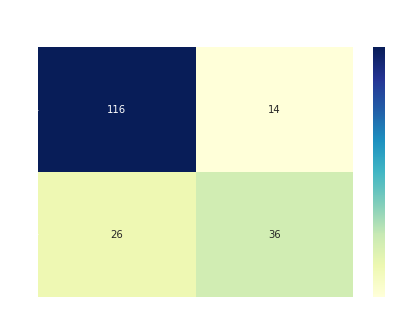

In [163]:
# Here we visualize the Logistic Regression confusion matrix using Heatmap.
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix- Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')